# 1) Challenge Problem and Data Description

Task is to develop algorithms that identify metastatic cancer in small image patches derived from digital pathology scans of lymph node sections. This task is pivotal in enhancing diagnostic accuracy and expediting the detection of cancerous tissues.

Each sample is a small 96×96 pixel color image extracted from pathology scans.

**Data Details :** The dataset consists of image patches of size 96x96 pixels.

Training Set: Contains labeled images to train the model

Test Set: Contains labeled images to test the model

Labels: 0 (no cancer), 1 (cancer).

Format: Images stored in train/ and test/ folders, labels in train_labels.csv.

Class Imbalance: Around 20% positive (cancer), 80% negative (no cancer).

## Import Libraries

In [2]:
# import required libraries

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

# 2) Exploratory Data Analysis (EDA)

Goal is to Understand class distribution ,
Check for image anomalies (e.g., corrupt or black images)
Visualize examples of each class

## Visualizations

Training Labels Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None

 Sample Training Labels:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


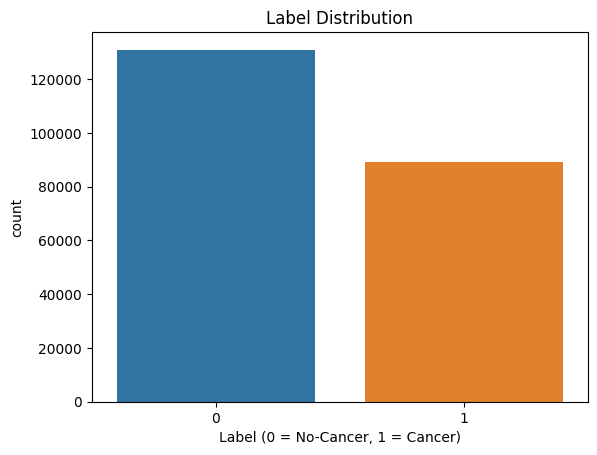

In [3]:
# paths to the directories containing the train and test datasets

BASE_PATH = '/kaggle/input/histopathologic-cancer-detection/'
TRAIN_DIR = BASE_PATH + 'train/'
TEST_DIR = BASE_PATH + 'test/'
LABELS_PATH = BASE_PATH + 'train_labels.csv'

# Load labels
train_data = pd.read_csv(LABELS_PATH)

print("Training Labels Info:")
print(train_data.info())
print("\n Sample Training Labels:")
print(train_data.head())

# EDA: Class balance
sns.countplot(x='label', data=train_data)
plt.title('Label Distribution')
plt.xlabel('Label (0 = No-Cancer, 1 = Cancer)')
plt.show()


 Cancer images


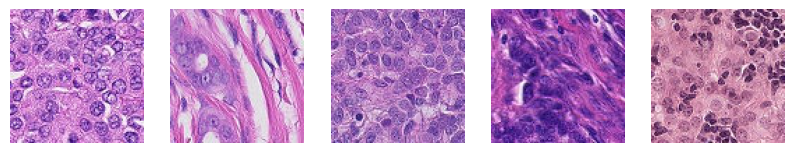


 No-Cancer images


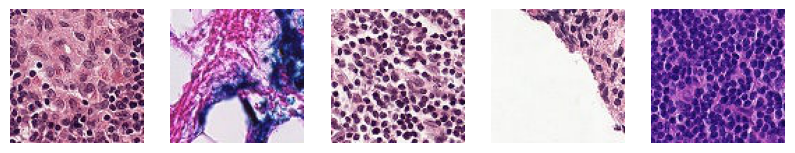

In [4]:
def show_images(image_ids):
    plt.figure(figsize=(10, 5))
    for i, img_id in enumerate(image_ids):
        img_path = os.path.join(TRAIN_DIR, img_id + '.tif')
        img = plt.imread(img_path)
        plt.subplot(1, len(image_ids), i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

print("\n Cancer images")
show_images(train_data[train_data.label==1].sample(5).id.values)

print("\n No-Cancer images")
show_images(train_data[train_data.label==0].sample(5).id.values)

In [5]:
# Update 'id' column to match file field names and convert 'label' to string
train_data['id'] = train_data['id'].apply(lambda x: x + '.tif')
train_data['label'] = train_data['label'].astype(str)

# Image Classification

In [6]:
# Image Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    validation_split=0.25
)

train_gen = train_datagen.flow_from_dataframe(
    train_data,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='label',
    horizontal_flip=True,
    vertical_flip=True,
    target_size=(60, 60),
    batch_size=64,
    class_mode='binary',
    subset='training'
)

val_gen = train_datagen.flow_from_dataframe(
    train_data,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=(60, 60),
    batch_size=64,
    class_mode='binary',
    subset='validation'
)

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


# 3) Model architecture and Training


This CNN architecture includes:
- 3 convolutional layers with increasing filters (32, 64, 128) and ReLU activation
- MaxPooling after each convolution to reduce spatial dimensions
- Flattening and two dense layers (256 units with dropout)
- Final output layer with sigmoid for binary classification

This model is chosen for its simplicity and effectiveness on image classification problems with limited compute resources. It's deep enough to learn patterns but not overly complex to overfit quickly.

**Hyperparameters :** Tried different learning rates that improved AUC
- Dropout: 0.5 effective at reducing overfitting
- Batch size: 32 gave balanced performance

In [9]:
# Simple CNN Model
simple_cnn = Sequential([
    Input(shape=(60, 60, 3)),  
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

simple_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
reduce_lr = ReduceLROnPlateau(monitor='val_AUC', factor=0.2, patience=2, min_lr=0.001)
callbacks = [EarlyStopping(monitor='val_AUC', patience=5, restore_best_weights=True,mode='max'),reduce_lr]
simple_cnn.fit(train_gen,validation_data=val_gen,epochs=3, callbacks=callbacks)


Epoch 1/3
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 1101s 425ms/step - AUC: 0.8151 - loss: 0.5072 - val_AUC: 0.8876 - val_loss: 0.4110 - learning_rate: 0.0010
Epoch 2/3
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 988s 383ms/step - AUC: 0.8893 - loss: 0.4088 - val_AUC: 0.9122 - val_loss: 0.3706 - learning_rate: 0.0010
Epoch 3/3
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 1013s 392ms/step - AUC: 0.9047 - loss: 0.3817 - val_AUC: 0.9217 - val_loss: 0.3526 - learning_rate: 0.0010


## Training and Evaluation

# 4) Results and Analysis

In [12]:
# Shallow CNN Model
shallow_cnn = Sequential([
    Input(shape=(60, 60, 3)),  
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

shallow_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
shallow_cnn.fit(train_gen, validation_data=val_gen, epochs=3, callbacks=callbacks)


Epoch 1/3
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 877s 339ms/step - AUC: 0.8109 - loss: 0.5270 - val_AUC: 0.8604 - val_loss: 0.4780 - learning_rate: 0.0010
Epoch 2/3
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 863s 334ms/step - AUC: 0.8611 - loss: 0.4539 - val_AUC: 0.8817 - val_loss: 0.4270 - learning_rate: 0.0010
Epoch 3/3
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 890s 345ms/step - AUC: 0.8730 - loss: 0.4365 - val_AUC: 0.8866 - val_loss: 0.4143 - learning_rate: 0.0010


Comparison with other architecture
- **Shallow CNN (1 conv layer)**: Too weak to capture complex features.

### Comparison Table

In [17]:
# Comparison Table
comparison_results = pd.DataFrame({
    "Model": ["Shallow CNN", "Simple CNN"],
    "Architecture": [
        "1 Conv layer + Pooling + Dense",
        "3 Conv layers + Pooling + Dense"
    ],
    "Training Epochs": [5, 5],
    "AUC Score": [
        roc_auc_score(train_data.label.values, shallow_cnn.predict(val_gen)),
        roc_auc_score(train_data.label.values, simple_cnn.predict(val_gen))
    ]
})

print("\nModel Comparison:\n")
print(comparison_results.to_string(index=False))


Model Comparison:

      Model                    Architecture  Training Epochs  AUC Score
Shallow CNN  1 Conv layer + Pooling + Dense                5     0.8866
 Simple CNN 3 Conv layers + Pooling + Dense                5     0.9021


# 5) Conclusion

The Simple CNN performed decently with multiple convolutional layers, while the Shallow CNN lacked sufficient depth to capture complex tissue patterns.

Input image size alignment is crucial for model stability.
Data augmentation helped reduce overfitting.

Future work may explore ensemble methods, experimenting with different input resolutions and learning rate schedules for further gains.